In [1]:
from utils.map_vis_without_lanelet import *

import numpy as np
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
%matplotlib inline

dict_keys(['guard_rail', 'line_thin_solid', 'line_thin_dashed'])


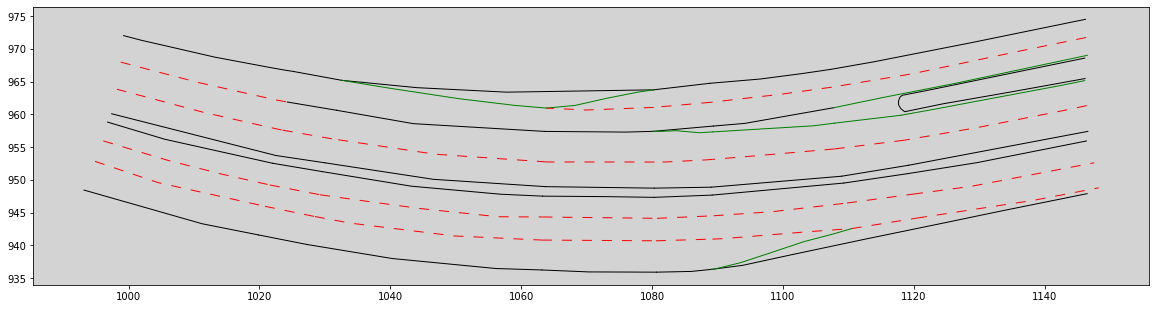

In [4]:
lat_origin = 0
lon_origin = 0

projector = LL2XYProjector(lat_origin, lon_origin)

fig, axes = plt.subplots(1, 1)
fig.set_size_inches(20,15)
axes.set_aspect('equal', adjustable='box')
axes.patch.set_facecolor('lightgrey')

map_file_list = ['DR_CHN_Merging_ZS.osm']

for f in map_file_list:
    map_file = '../maps/' + f

    tree = xml.parse(map_file).getroot()
    # for child in tree:
    #     print('child.tag', child.tag)
    #     print('child.attrib', child.attrib)

    point_dict = dict()
    for node in tree.findall("node"):
        point = Point()
        point.x, point.y = projector.latlon2xy(float(node.get('lat')), float(node.get('lon')))
        point_dict[int(node.get('id'))] = point
#     set_visible_area(point_dict, axes)
    
    way_dict = dict()
    unknown_linestring_types = list()
    for i, way in enumerate(tree.findall('way')):
        way_type = get_type(way)
        
        if get_subtype(way) is not None:
            way_type_subtype = way_type + '_' + get_subtype(way)
        else: 
            way_type_subtype = way_type
        
        x_list, y_list = get_x_y_lists(way, point_dict)
        if way_type_subtype not in way_dict.keys():
            way_dict[way_type_subtype] = [np.array([x_list, y_list])]
        else:
            way_dict[way_type_subtype].append(np.array([x_list, y_list]))
print(way_dict.keys())


for way_type_subtype, xy_list in way_dict.items():
#     print('\n', way_type_subtype, len(xy_list))
    
    if way_type_subtype == "curbstone_low":
        type_dict = dict(color="black", linewidth=1, zorder=10)
    elif way_type_subtype == "guard_rail":
        type_dict = dict(color="black", linewidth=1, zorder=10)
    elif way_type_subtype == "line_thin_dashed":
        type_dict = dict(color="red", linewidth=1, zorder=10, dashes=[10, 10])
    elif way_type_subtype == "line_thin_solid":
        type_dict = dict(color="green", linewidth=1, zorder=10)
        
    elif way_type_subtype == "pedestrian_marking":
        type_dict = dict(color="green", linewidth=1, zorder=10) #, dashes=[5, 10])
    elif way_type_subtype == "virtual":
        type_dict = dict(color="blue", linewidth=1, zorder=10) #, dashes=[2, 5])

    for i, xy in enumerate(xy_list):
        plt.plot(xy[0], xy[1], **type_dict)
plt.show()



type:  guard_rail
original way pieces:  34
index segments: {0: [0, 3, 7, 12, 20, 23], 1: [1, 4, 8, 13, 18, 24, 29, 30], 2: [2, 6, 11, 17, 21, 26], 3: [27, 25, 16, 14, 10], 4: [33, 31, 28, 22, 19, 15, 9, 5], 5: [32]}
extracted way segments: 6

type:  line_thin_solid
original way pieces:  8
index segments: {0: [1, 4, 5, 6], 1: [2, 0], 2: [3], 3: [7]}
extracted way segments: 4

type:  line_thin_dashed
original way pieces:  29
index segments: {0: [0, 3, 6, 9, 14, 18, 23, 26], 1: [1, 4, 7, 10, 15, 19, 22, 25], 2: [27, 20, 16, 12], 3: [28, 24, 21, 17, 13, 11, 8, 5], 4: [2]}
extracted way segments: 5


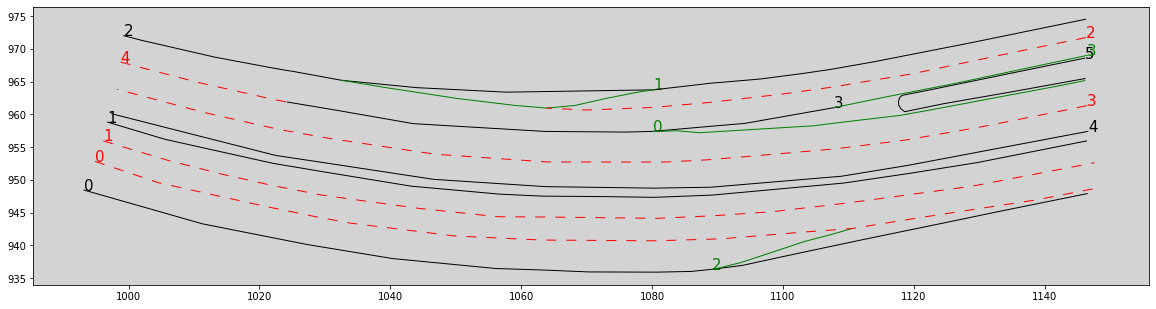

In [20]:
fig, axes = plt.subplots(1, 1)
fig.set_size_inches(20,15)
axes.set_aspect('equal', adjustable='box')
axes.patch.set_facecolor('lightgrey')

xy_all_segments = dict()
for way_type_subtype, xy_list in way_dict.items(): 
    print('\ntype: ', way_type_subtype)
    
    print('original way pieces: ', len(xy_list))
    sort_xy_list = sorted(xy_list, key=lambda x: x[0][0])  
    sort_ij_list = list(range(len(sort_xy_list)))

    ij_list_pairs = []
    for i, ij_i in enumerate(sort_ij_list):
        for j, ij_j in enumerate(sort_ij_list):
            if sort_xy_list[i][0,-1] == sort_xy_list[j][0,0] and sort_xy_list[i][1,-1] == sort_xy_list[j][1,0]:
                ij_list_pairs.append([ij_i, ij_j])

    ij_new_segments = dict()
    n = 0
    for i, j in ij_list_pairs:                
        if sum(ij_list_pairs, []).count(i) == 1:
            ij_new_segments[n] = [i, j]
            n += 1    
        elif sum(ij_list_pairs, []).count(i) == 2:
            for key, val in ij_new_segments.items():
                if val[-1] == i:
                    ij_new_segments[key].extend([j])              
    for i in sort_ij_list:
        if sum(ij_list_pairs, []).count(i) == 0:
            ij_new_segments[n] = [i]
            n += 1

    if sum([len(val) for val in ij_new_segments.values()]) != len(xy_list):
        go = False
        while go is False:
            for i, j in ij_list_pairs: 
                if sum(ij_list_pairs, []).count(i) == 2:
                    for key, val in ij_new_segments.items():
                        if val[-1] == i:
                            ij_new_segments[key].extend([j])  

            if sum([len(val) for val in ij_new_segments.values()]) == len(xy_list):
                go = True            
    print('index segments:', ij_new_segments)
        
    xy_new_segments = dict()
    n=0
    for key, value in ij_new_segments.items(): 
        x_new_segments = []
        y_new_segments = []
        for i, ind in enumerate(value):
            if i == 0:
                x_new_segments.extend(sort_xy_list[ind][0])
                y_new_segments.extend(sort_xy_list[ind][1])
            else:
                x_new_segments.extend(sort_xy_list[ind][0][1:])
                y_new_segments.extend(sort_xy_list[ind][1][1:])              
        xy_new_segments[n] = np.array([x_new_segments, y_new_segments])
        n += 1
    xy_all_segments[way_type_subtype] = xy_new_segments
    print('extracted way segments:', len(xy_new_segments.keys()))
        
for way_type_subtype, xy_new_segments in xy_all_segments.items(): 
    if way_type_subtype == "guard_rail":
        type_dict = dict(color="black", linewidth=1, zorder=10)
        text_dict = dict(color="black", fontsize=15)
    elif way_type_subtype == "line_thin_dashed":
        type_dict = dict(color="red", linewidth=1, zorder=10, dashes=[10, 10])
        text_dict = dict(color="red", fontsize=15)
    elif way_type_subtype == "line_thin_solid":
        type_dict = dict(color="green", linewidth=1, zorder=10)
        text_dict = dict(color="green", fontsize=15)
        
    for i, xy in xy_new_segments.items():
        plt.plot(xy[0], xy[1], **type_dict)
        plt.text(xy[0][0], xy[1][0], i, **text_dict)
plt.show()     


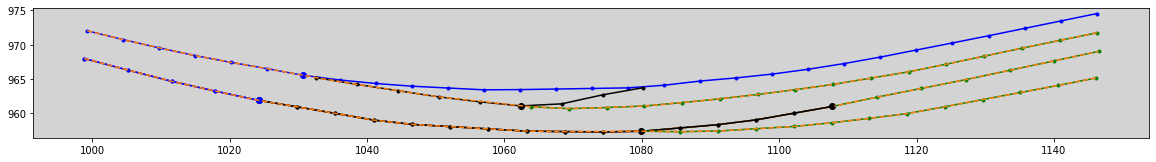

In [11]:
def combine_lanes(n, first_type, first_i, second_type, second_i, third_type, third_i):        
    dist_threshold = 5
    
    for way_type_subtype, xy_new_segments in xy_all_segments.items():             
        for i, xy in xy_new_segments.items():
            if way_type_subtype == first_type and i == first_i:
                xy_1 = np.column_stack((xy[0], xy[1]))
                length_1 = np.sum([np.linalg.norm(xy - xy_1[j+1], 2) for j, xy in enumerate(xy_1[:-1])])
                f = interp1d(xy_1[:,0], xy_1[:,1])
                xnew_1 = np.linspace(xy_1[0,0], xy_1[-1,0], num=int(length_1//n)) #len(xy_1[0])*3, endpoint=True)
                ynew_1 = f(xnew_1)
                xynew_1 = np.column_stack((xnew_1, ynew_1))
                plt.plot(xynew_1[:,0], xynew_1[:,1], 'b.-')

            elif way_type_subtype == second_type and i == second_i:
                xy_2 = np.column_stack((xy[0], xy[1]))
                length_2 = np.sum([np.linalg.norm(xy - xy_2[j+1], 2) for j, xy in enumerate(xy_2[:-1])])
                f = interp1d(xy_2[:,0], xy_2[:,1])
                xnew_2 = np.linspace(xy_2[0,0], xy_2[-1,0], num=int(length_2//n)) #num=len(xy_2[0])*3, endpoint=True)
                ynew_2 = f(xnew_2)
                xynew_2 = np.column_stack((xnew_2, ynew_2))
                plt.plot(xynew_2[:,0], xynew_2[:,1], 'k.-')

            elif way_type_subtype == third_type and i == third_i:
                xy_3 = np.column_stack((xy[0], xy[1]))
                length_3 = np.sum([np.linalg.norm(xy - xy_3[j+1], 2) for j, xy in enumerate(xy_3[:-1])])
                f = interp1d(xy_3[:,0], xy_3[:,1])
                xnew_3 = np.linspace(xy_3[0,0], xy_3[-1,0], num=int(length_3//n)) #len(xy_3[0]), endpoint=True)
                ynew_3 = f(xnew_3)
                xynew_3 = np.column_stack((xnew_3, ynew_3))
                plt.plot(xynew_3[:,0], xynew_3[:,1], 'g.-')

    dist_12_first = [np.linalg.norm(xy_1 - xynew_2[0,:], 2) for xy_1 in xynew_1]
    dist_12_last = [np.linalg.norm(xy_1 - xynew_2[-1,:], 2) for xy_1 in xynew_1]
    if np.min(dist_12_first) < dist_threshold and np.min(dist_12_last) < dist_threshold and np.min(dist_12_first) < np.min(dist_12_last):
        ind_12 = np.argmin(dist_12_first)
        rev_2 = 1
    elif np.min(dist_12_first) < dist_threshold and np.min(dist_12_last) < dist_threshold and np.min(dist_12_first) > np.min(dist_12_last):
        ind_12 = np.argmin(dist_12_last)
        rev_2 = -1
    elif np.min(dist_12_first) < dist_threshold and np.min(dist_12_last) > dist_threshold:
        ind_12 = np.argmin(dist_12_first)
        rev_2 = 1
    elif np.min(dist_12_first) > dist_threshold and np.min(dist_12_last) < dist_threshold:
        ind_12 = np.argmin(dist_12_last)
        rev_2 = -1
    else:
        print('error: ind_12', np.min(dist_12_first), np.min(dist_12_last))
    plt.plot(xynew_1[ind_12,0], xynew_1[ind_12,1], 'bo')
    
    
    dist_23_first = [np.linalg.norm(xy_2 - xynew_3[0,:], 2) for xy_2 in xynew_2]
    dist_23_last = [np.linalg.norm(xy_2 - xynew_3[-1,:], 2) for xy_2 in xynew_2]
    if np.min(dist_23_first) < dist_threshold and np.min(dist_23_last) < dist_threshold and np.min(dist_23_first) < np.min(dist_23_last):
        ind_23 = np.argmin(dist_23_first)
        rev_3 = 1
    elif np.min(dist_23_first) < dist_threshold and np.min(dist_23_last) < dist_threshold and np.min(dist_23_first) > np.min(dist_23_last):
        ind_23 = np.argmin(dist_23_last)
        rev_3 = -1
    elif np.min(dist_23_first) < dist_threshold and np.min(dist_23_last) > dist_threshold:
        ind_23 = np.argmin(dist_23_first)
        rev_3 = 1
    elif np.min(dist_23_first) > dist_threshold and np.min(dist_23_last) < dist_threshold:
        ind_23 = np.argmin(dist_23_last)
        rev_3 = -1
    else:
        print('error: ind_23')
    plt.plot(xynew_2[ind_23,0], xynew_2[ind_23,1], 'ko')
  
    x_combined = np.concatenate((xynew_1[:ind_12+1:1,0], xynew_2[:ind_23+1:rev_2,0], xynew_3[::rev_3,0]))
    y_combined = np.concatenate((xynew_1[:ind_12+1:1,1], xynew_2[:ind_23+1:rev_2,1], xynew_3[::rev_3,1]))
    plt.plot(x_combined, y_combined, color='#ff7f0e', linestyle='--')  
    
    return [list(x_combined), list(y_combined)]


if "combined" not in xy_all_segments.keys():
    xy_all_segments["combined"] = dict()
      
fig, axes = plt.subplots(1, 1)
fig.set_size_inches(20,15)
axes.set_aspect('equal', adjustable='box')
axes.patch.set_facecolor('lightgrey')

xy_all_segments["combined"][0] = combine_lanes(n, "guard_rail", 2, "line_thin_solid", 1, "line_thin_dashed", 2)
xy_all_segments["combined"][1] = combine_lanes(n, "line_thin_dashed", 4, "guard_rail", 3, "line_thin_solid", 3)
xy_all_segments["combined"][2] = combine_lanes(n, "line_thin_dashed", 4, "guard_rail", 3, "line_thin_solid", 0)


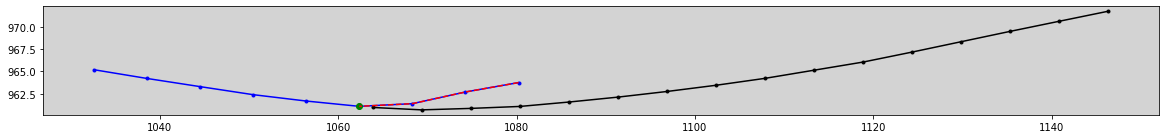

In [12]:
def trim_lanes(n, trimmed_type, trimmed_i, trimming_type, trimming_i):
    for way_type_subtype, xy_new_segments in xy_all_segments.items():             
        for i, xy in xy_new_segments.items():
            if way_type_subtype == trimmed_type and i == trimmed_i:
                xy_1 = np.column_stack((xy[0], xy[1]))
                length_1 = np.sum([np.linalg.norm(xy - xy_1[j+1], 2) for j, xy in enumerate(xy_1[:-1])])
                f = interp1d(xy_1[:,0], xy_1[:,1])
                xnew_1 = np.linspace(xy_1[0,0], xy_1[-1,0], num=int(length_1//n)) #len(xy_1[0])*3, endpoint=True)
                ynew_1 = f(xnew_1)
                xynew_1 = np.column_stack((xnew_1, ynew_1))
                plt.plot(xynew_1[:,0], xynew_1[:,1], 'b.-')

            elif way_type_subtype == trimming_type and i == trimming_i:
                xy_2 = np.column_stack((xy[0], xy[1]))
                length_2 = np.sum([np.linalg.norm(xy - xy_2[j+1], 2) for j, xy in enumerate(xy_2[:-1])])
                f = interp1d(xy_2[:,0], xy_2[:,1])
                xnew_2 = np.linspace(xy_2[0,0], xy_2[-1,0], num=int(length_2//n)) #num=len(xy_2[0])*3, endpoint=True)
                ynew_2 = f(xnew_2)
                xynew_2 = np.column_stack((xnew_2, ynew_2))
                plt.plot(xynew_2[:,0], xynew_2[:,1], 'k.-')
        
    dist_first = [np.linalg.norm(xy_1 - xynew_2[0,:], 2) for xy_1 in xynew_1]
    dist_last = [np.linalg.norm(xy_1 - xynew_2[-1,:], 2) for xy_1 in xynew_1]
    if dist_first < dist_last:
        ind = np.argmin(dist_first)
    elif dist_first > dist_last:
        ind = np.argmin(dist_last)
    plt.plot(xynew_1[ind, 0], xynew_1[ind, 1], 'go')
    plt.plot(xynew_1[:ind+1, 0], xynew_1[:ind+1, 1], 'r--')
    
    return [list(xynew_1[:ind+1, 0]), list(xynew_1[:ind+1, 1])]


if "trimmed" not in xy_all_segments.keys():
    xy_all_segments["trimmed"] = dict()
    
fig, axes = plt.subplots(1, 1)
fig.set_size_inches(20,15)
axes.set_aspect('equal', adjustable='box')
axes.patch.set_facecolor('lightgrey')

xy_all_segments["trimmed"][0] = trim_lanes(n, "line_thin_solid", 1, "line_thin_dashed", 2)


In [13]:
def draw_centerline(n, first_type, first_i, second_type, second_i, txt_filename):
    for way_type_subtype, xy_new_segments in xy_all_segments.items():             
        for i, xy in xy_new_segments.items():
            if way_type_subtype == first_type and i == first_i:
                xy_1 = np.column_stack((xy[0], xy[1]))
                f_1 = interp1d(xy_1[:,0], xy_1[:,1])
                length_1 = np.sum([np.linalg.norm(xy - xy_1[j+1], 2) for j, xy in enumerate(xy_1[:-1])])

            elif way_type_subtype == second_type and i == second_i:
                xy_2 = np.column_stack((xy[0], xy[1]))
                f_2 = interp1d(xy_2[:,0], xy_2[:,1])
                length_2 = np.sum([np.linalg.norm(xy - xy_2[j+1], 2) for j, xy in enumerate(xy_2[:-1])])
                
    length = max(length_1, length_2)
    xnew_1 = np.linspace(xy_1[0,0], xy_1[-1,0], num=int(length//n)) #len(xy_1[0])*3, endpoint=True)
    ynew_1 = f_1(xnew_1)
    xynew_1 = np.column_stack((xnew_1, ynew_1))
    plt.plot(xynew_1[:,0], xynew_1[:,1], 'k-')

    xnew_2 = np.linspace(xy_2[0,0], xy_2[-1,0], num=int(length//n)) #num=len(xy_2[0])*3, endpoint=True)
    ynew_2 = f_2(xnew_2)
    xynew_2 = np.column_stack((xnew_2, ynew_2))
    plt.plot(xynew_2[:,0], xynew_2[:,1], 'k-')
    
    if (xynew_1[0,0] - xynew_1[-1,0] > 0) != (xynew_2[0,0] - xynew_2[-1,0] > 0):
        xynew_2 = xynew_2[::-1]

    xy_center = np.empty((len(xynew_1), 2))
    for i, xy in enumerate(xynew_1):
        xy_1 = xy
        xy_2 = xynew_2[i]
        xy_center[i, :] = (xy_1 + xy_2) / 2
    plt.plot(xy_center[:,0], xy_center[:,1], color='#1f77b4', linestyle='-.')

#     print(txt_filename, "xy_center: \n", xy_center.tolist(), "\n")
    np.savetxt(txt_filename, [xy_center[:,0], xy_center[:,1]], delimiter=',')
    

In [14]:
def draw_centerline_merging(n, first_type, first_i, merged_type, merged_i, merging_type, merging_i, txt_filename):
    for way_type_subtype, xy_new_segments in xy_all_segments.items():             
        for i, xy in xy_new_segments.items():

            if way_type_subtype == first_type and i == first_i:
                xy_1 = np.column_stack((xy[0], xy[1]))
                length_1 = np.sum([np.linalg.norm(xy - xy_1[j+1], 2) for j, xy in enumerate(xy_1[:-1])])
                f = interp1d(xy_1[:,0], xy_1[:,1])
                xnew_1 = np.linspace(xy_1[0,0], xy_1[-1,0], num=int(length_1//n)) 
                ynew_1 = f(xnew_1)
                xynew_1 = np.column_stack((xnew_1, ynew_1))
                plt.plot(xynew_1[:,0], xynew_1[:,1], 'k-')

            elif way_type_subtype == merged_type and i == merged_i:
                xy_2 = np.column_stack((xy[0], xy[1]))
                length_2 = np.sum([np.linalg.norm(xy - xy_2[j+1], 2) for j, xy in enumerate(xy_2[:-1])])
                f = interp1d(xy_2[:,0], xy_2[:,1])
                xnew_2 = np.linspace(xy_2[0,0], xy_2[-1,0], num=int(length_2//n)) 
                ynew_2 = f(xnew_2)
                xynew_2 = np.column_stack((xnew_2, ynew_2))
                plt.plot(xynew_2[:,0], xynew_2[:,1], 'k-')

            elif way_type_subtype == merging_type and i == merging_i:
                xy_3 = np.column_stack((xy[0], xy[1]))
                length_3 = np.sum([np.linalg.norm(xy - xy_3[j+1], 2) for j, xy in enumerate(xy_3[:-1])])
                f = interp1d(xy_3[:,0], xy_3[:,1])
                xnew_3 = np.linspace(xy_3[0,0], xy_3[-1,0], num=int(length_3//n)) #len(xy_3[0]), endpoint=True)
                ynew_3 = f(xnew_3)
                xynew_3 = np.column_stack((xnew_3, ynew_3))
                plt.plot(xynew_3[:,0], xynew_3[:,1], 'r-')           
    
    if (xynew_1[0,0] - xynew_1[-1,0] > 0) != (xynew_3[0,0] - xynew_3[-1,0] > 0):
        xynew_1 = xynew_1[::-1]
    if (xynew_2[0,0] - xynew_2[-1,0] > 0) != (xynew_3[0,0] - xynew_3[-1,0] > 0):
        xynew_2 = xynew_2[::-1]   

    ind_1 = np.argmin([np.linalg.norm(xy_1 - xynew_3[-1,:], 2) for xy_1 in xynew_1])
    ind_2 = np.argmin([np.linalg.norm(xy_2 - xynew_3[0,:], 2) for xy_2 in xynew_2])
#     plt.plot(xynew_1[ind_1, 0], xynew_1[ind_1, 1], 'go')
#     plt.plot(xynew_2[ind_2, 0], xynew_2[ind_2, 1], 'bo')

    xy_center_merged = np.empty((len(xynew_2[:ind_2+1,:]), 2))    
    for i, xy in enumerate(xynew_2[:ind_2+1,:]):
        xy_1 = xynew_1[i]
        xy_2 = xy
        xy_center_merged[i, :] = (xy_1 + xy_2) / 2
#     plt.plot(xy_center_merged[:,0], xy_center_merged[:,1], color='#1f77b4', linestyle='--') #, marker='o')

    xy_center_merging = np.empty((len(xynew_3), 2))
    for i, xy_3 in enumerate(xynew_3[:-1,:]):
        slope, intercept = np.polyfit([xynew_3[i,0],xynew_3[i+1,0]], [xynew_3[i,1], xynew_3[i+1,1]], 1)
        intercept_new = intercept + xy_center_merged[-1,:] - xynew_3[0,:]
        x_new = [xynew_3[i,0], xynew_3[i+1,0]]
        y_new = [slope * x + intercept_new[1] for x in x_new]
        
        xy_center_merging[i,0] = x_new[0]
        xy_center_merging[i,1] = y_new[0]
        
        if i == len(xynew_3)-2:
            xy_center_merging[i+1,0] = x_new[1]
            xy_center_merging[i+1,1] = y_new[1]
#     plt.plot(xy_center_merging[:,0], xy_center_merging[:,1], color='#1f77b4', linestyle='--')
    
    xy_center_all = np.concatenate((xy_center_merged[:-1,:], xy_center_merging))
    plt.plot(xy_center_all[:,0], xy_center_all[:,1], color='#1f77b4', linestyle='-.')

#     print(txt_filename, "xy_center_all: \n", xy_center_all.tolist(), "\n")
    np.savetxt(txt_filename, [xy_center_all[:,0], xy_center_all[:,1]], delimiter=',')
    

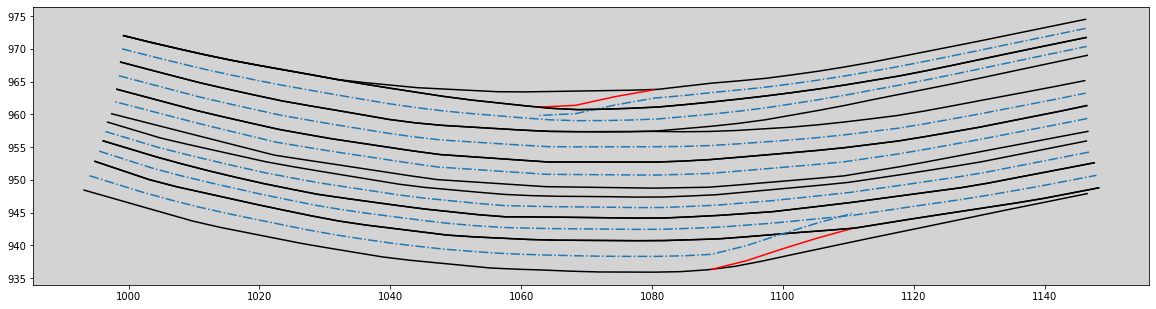

In [15]:
fig, axes = plt.subplots(1, 1)
fig.set_size_inches(20,15)
axes.set_aspect('equal', adjustable='box')
axes.patch.set_facecolor('lightgrey')

n = 4

draw_centerline_merging(n, "combined", 0, "guard_rail", 2, "trimmed", 0, "./output_files/output_centerline_0.txt")
draw_centerline(n, "combined", 0, "combined", 1, "./output_files/output_centerline_1.txt")
draw_centerline(n, "combined", 2, "line_thin_dashed", 3, "./output_files/output_centerline_2.txt")
draw_centerline(n, "line_thin_dashed", 3, "guard_rail", 4, "./output_files/output_centerline_3.txt")
draw_centerline(n, "line_thin_dashed", 1, "guard_rail", 1, "./output_files/output_centerline_4.txt")
draw_centerline(n, "line_thin_dashed", 0, "line_thin_dashed", 1, "./output_files/output_centerline_5.txt")
draw_centerline_merging(n, "line_thin_dashed", 0, "guard_rail", 0, "line_thin_solid", 2, "./output_files/output_centerline_6.txt") 

plt.savefig('./output_files/output_centerlines.pdf')


In [ ]:
# colors_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
# '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


### Reading saved .txt files

In [18]:

f = open('output_files/output_centerline_1.txt', 'r')
x = f.readlines()
f.close()
print(type(x))
print(x)


<class 'list'>
['9.990155760662164539e+02,1.003109771814143187e+03,1.007203967562069806e+03,1.011298163309996539e+03,1.015392359057923159e+03,1.019486554805849892e+03,1.023580750553776511e+03,1.027674946301703130e+03,1.031769142049629863e+03,1.035863337797556596e+03,1.039957533545483329e+03,1.044051729293410062e+03,1.048145925041336568e+03,1.052240120789263301e+03,1.056334316537190034e+03,1.060428512285116767e+03,1.064522708033043273e+03,1.068616903780970006e+03,1.072711099528896739e+03,1.076805295276823472e+03,1.080899491024750205e+03,1.084993686772676710e+03,1.089087882520603443e+03,1.093182078268530177e+03,1.097276274016456910e+03,1.101370469764383415e+03,1.105464665512310148e+03,1.109558861260236881e+03,1.113653057008163614e+03,1.117747252756090347e+03,1.121841448504016853e+03,1.125935644251943586e+03,1.130029839999870319e+03,1.134124035747797052e+03,1.138218231495723558e+03,1.142312427243650291e+03,1.146406622991577024e+03\n', '9.700083658697267310e+02,9.689655970964220160e+02,9.6